In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification, AutoProcessor
from pathlib import Path
from torchvision.transforms import ToPILImage

import sys; sys.path.append("../src/")
from stability import soft_stability_rate
from models import MaskedImageClassifier, CertifiedMuSImageClassifier
from data_utils import load_images_from_directory
from explanations import \
    get_lime_for_image, get_shap_for_image, get_intgrad_for_image, get_mfaba_for_image, get_random_for_image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
processor = AutoProcessor.from_pretrained('google/vit-base-patch16-224')

In [3]:
# Load images; they will be ordered the same every time.
images = load_images_from_directory("/shared_data0/helenjin/imagenet-sample-images/")
# images = images[:20]
images = torch.tensor([processor(ToPILImage()(img))['pixel_values'] for img in images]).squeeze()
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [4]:
# Load the model. This should be our custom fine-tuned models later!
raw_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
raw_vit.eval().to(device);

In [5]:
wrapped_vit = MaskedImageClassifier(raw_vit)
wrapped_vit.eval().to(device);

## Explanations take a while to generate, so we recommend using the cached version

In [6]:
prefix = "/shared_data0/helenjin/ssg/notebooks/"

In [103]:
# Generating explanations is expensive, so we'll cache things as needed
use_cache = True # Set to false if you wanna do it from scratch
cache_dir = Path("_cache")
lime_cache_file = prefix / cache_dir / "vit_lime.pt"
shap_cache_file = prefix / cache_dir / "vit_shap.pt"
intgrad_cache_file = prefix / cache_dir / "vit_intgrad.pt"
mfaba_cache_file = prefix /  cache_dir / "vit_mfaba.pt"
random_cache_file = prefix /  cache_dir / "vit_random.pt"
cache_dir.mkdir(parents=True, exist_ok=True)

In [8]:
return_verbose = True
if return_verbose:
    cache_dir_full = Path(f"{prefix}_cache/full_expln_output")
    cache_dir_full.mkdir(parents=True, exist_ok=True)
    
    cache_dir_attrs = Path(f"{prefix}_cache/attrs")
    cache_dir_attrs.mkdir(parents=True, exist_ok=True)

In [9]:
# return_verbose = False

In [10]:
if lime_cache_file.exists() and use_cache:
    lime_explanations = torch.load(lime_cache_file)
else:
    print("Running LIME")
    if return_verbose:
        print("Saving everything")
        lime_explanations = []
        for i, img in enumerate(tqdm(images)):
            lime_expln_alpha, lime_expln, lime_expln_attrs = get_lime_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(lime_expln, cache_dir_full / f'vit_lime_img{i}.pt')
            torch.save(lime_expln_attrs, cache_dir_attrs / f'vit_lime_img{i}.pt')
            lime_explanations.append(lime_expln_alpha)
        lime_explanations = torch.stack(lime_explanations)
    else:
        print("Saving just masked explanations")
        lime_explanations = torch.stack([get_lime_for_image(wrapped_vit, img) for img in tqdm(images)])
    lime_explanations = torch.squeeze(lime_explanations)
    torch.save(lime_explanations, lime_cache_file)
print("LIME explanations", lime_explanations.shape)

LIME explanations torch.Size([1000, 14, 14])


In [11]:
if shap_cache_file.exists() and use_cache:
    shap_explanations = torch.load(shap_cache_file)
else:
    print("Running SHAP")
    if return_verbose:
        print("Saving everything")
        shap_explanations = []
        for i, img in enumerate(tqdm(images)):
            shap_expln_alpha, shap_expln, shap_expln_attrs = get_shap_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(shap_expln, cache_dir_full / f'vit_shap_img{i}.pt')
            torch.save(shap_expln_attrs, cache_dir_attrs / f'vit_shap_img{i}.pt')
            shap_explanations.append(shap_expln_alpha)
        shap_explanations = torch.stack(shap_explanations)
    else:
        print("Saving just masked explanations")
        shap_explanations = torch.stack([get_shap_for_image(wrapped_vit, img) for img in tqdm(images)])
    shap_explanations = torch.squeeze(shap_explanations)
    torch.save(shap_explanations, shap_cache_file)
print("SHAP explanations", shap_explanations.shape)

SHAP explanations torch.Size([1000, 14, 14])


In [12]:
if intgrad_cache_file.exists() and use_cache:
    intgrad_explanations = torch.load(intgrad_cache_file)
else:
    print("Running Integrated Gradients")
    if return_verbose:
        print("Saving everything")
        intgrad_explanations = []
        for i, img in enumerate(tqdm(images)):
            intgrad_expln_alpha, intgrad_expln, intgrad_expln_attrs = get_intgrad_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(intgrad_expln, cache_dir_full / f'vit_intgrad_img{i}.pt')
            torch.save(intgrad_expln_attrs, cache_dir_attrs / f'vit_intgrad_img{i}.pt')
            intgrad_explanations.append(intgrad_expln_alpha)
        intgrad_explanations = torch.stack(intgrad_explanations)
    else:
        print("Saving just masked explanations")
        intgrad_explanations = torch.stack([get_intgrad_for_image(wrapped_vit, img) for img in tqdm(images)])
    intgrad_explanations = torch.squeeze(intgrad_explanations)
    torch.save(intgrad_explanations, intgrad_cache_file)
print("Integrated Gradient explanations", intgrad_explanations.shape)

Integrated Gradient explanations torch.Size([1000, 14, 14])


In [31]:
if mfaba_cache_file.exists() and use_cache:
    mfaba_explanations = torch.load(mfaba_cache_file)
else:
    print("Running MFABA")
    if return_verbose:
        print("Saving everything")
        mfaba_explanations = []
        for i, img in enumerate(tqdm(images)):
            mfaba_expln_alpha, mfaba_expln, mfaba_expln_attrs = get_mfaba_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(mfaba_expln, cache_dir_full / f'vit_mfaba_img{i}.pt')
            torch.save(mfaba_expln_attrs, cache_dir_attrs / f'vit_mfaba_img{i}.pt')
            mfaba_explanations.append(mfaba_expln_alpha)
        mfaba_explanations = torch.stack(mfaba_explanations)
    else:
        print("Saving just masked explanations")
        mfaba_explanations = torch.stack([get_mfaba_for_image(raw_vit, img) for img in tqdm(images)])
    mfaba_explanations = torch.squeeze(mfaba_explanations)
    torch.save(mfaba_explanations, mfaba_cache_file)
print("MFABA explanations", mfaba_explanations.shape)

MFABA explanations torch.Size([1000, 14, 14])


In [35]:
mfaba_explanations.shape

torch.Size([1000, 14, 14])

In [108]:
if random_cache_file.exists() and use_cache:
    random_explanations = torch.load(random_cache_file)
else:
    print("Running Random")  
    print("Saving just masked explanations")
    random_explanations = torch.stack([get_random_for_image() for _ in tqdm(images)])
    random_explanations = torch.squeeze(random_explanations)
    # torch.save(random_explanations, random_cache_file)
print("Random explanations", random_explanations.shape)

Random explanations torch.Size([1000, 14, 14])


## Soft stability rates for different models

In [14]:
top_k_frac = 0.25 # need to check if this is true (but by default our explanations are 0.25 of the full input)

In [15]:
masked_vit = MaskedImageClassifier(raw_vit, grid_size=(14,14))
masked_vit.eval().to(device)
eps, delta = 0.1, 0.1
max_radius = int(196 * (1 - top_k_frac))
all_radius = [1] + list(range(10, max_radius, 10))
if all_radius[-1] != max_radius:
    all_radius.append(max_radius)
print(all_radius)

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 147]


In [29]:
lime_stability_rates_file = cache_dir / "vit_lime_stability_rates.pt"
shap_stability_rates_file = cache_dir / "vit_shap_stability_rates.pt"
intgrad_stability_rates_file = cache_dir / "vit_intgrad_stability_rates.pt"
mfaba_stability_rates_file = cache_dir / "vit_mfaba_stability_rates.pt"
random_stability_rates_file = cache_dir / "vit_random_stability_rates.pt"

In [17]:
if lime_stability_rates_file.exists() and use_cache:
    print("Loading LIME soft stability rates")
    lime_stability_rates = torch.load(lime_stability_rates_file)
else:
    print("Computing LIME soft stability rates")
    lime_stability_rates = []
    for img, exp in tqdm(zip(images, lime_explanations), total=len(images)):
        lime_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    lime_stability_rates = torch.stack(lime_stability_rates).cpu()
    torch.save(lime_stability_rates, lime_stability_rates_file)

Computing LIME soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
lime_stability_rates

tensor([[0.9267, 0.6800, 0.6000,  ..., 0.1733, 0.1733, 0.1867],
        [0.7133, 0.6333, 0.7467,  ..., 0.8933, 0.9200, 0.8733],
        [0.9933, 0.8800, 0.6067,  ..., 0.0867, 0.0800, 0.0800],
        ...,
        [0.9800, 0.2800, 0.0600,  ..., 0.0000, 0.0000, 0.0000],
        [0.9800, 0.7800, 0.5733,  ..., 0.0067, 0.0200, 0.0133],
        [1.0000, 0.8133, 0.6933,  ..., 0.9733, 0.9667, 0.9800]])

In [19]:
if shap_stability_rates_file.exists() and use_cache:
    print("Loading SHAP soft stability rates")
    shap_stability_rates = torch.load(shap_stability_rates_file)
else:
    print("Computing SHAP soft stability rates")
    shap_stability_rates = []
    for img, exp in tqdm(zip(images, shap_explanations), total=len(images)):
        shap_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    shap_stability_rates = torch.stack(shap_stability_rates).cpu()
    torch.save(shap_stability_rates, shap_stability_rates_file)

Computing SHAP soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
if intgrad_stability_rates_file.exists() and use_cache:
    print("Loading IntGrad soft stability rates")
    intgrad_stability_rates = torch.load(intgrad_stability_rates_file)
else:
    print("Computing IntGrad soft stability rates")
    intgrad_stability_rates = []
    for img, exp in tqdm(zip(images, intgrad_explanations), total=len(images)):
        intgrad_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    intgrad_stability_rates = torch.stack(intgrad_stability_rates).cpu()
    torch.save(intgrad_stability_rates, intgrad_stability_rates_file)

Computing IntGrad soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
if mfaba_stability_rates_file.exists() and use_cache:
    print("Loading MFABA soft stability rates")
    mfaba_stability_rates = torch.load(mfaba_stability_rates_file)
else:
    print("Computing MFABA soft stability rates")
    mfaba_stability_rates = []
    for img, exp in tqdm(zip(images, mfaba_explanations), total=len(images)):
        mfaba_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    mfaba_stability_rates = torch.stack(mfaba_stability_rates).cpu()
    torch.save(mfaba_stability_rates, mfaba_stability_rates_file)

Computing MFABA soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
if random_stability_rates_file.exists() and use_cache:
    print("Loading Random soft stability rates")
    random_stability_rates = torch.load(random_stability_rates_file)
else:
    print("Computing Random soft stability rates")
    random_stability_rates = []
    for img, exp in tqdm(zip(images, random_explanations), total=len(images)):
        random_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    random_stability_rates = torch.stack(random_stability_rates).cpu()
    torch.save(random_stability_rates, random_stability_rates_file)

Computing Random soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [127]:
torch.cat([torch.tensor([1]), lime_stability_rates.cpu().mean(dim=0)]).numpy().shape

(17,)

<Figure size 640x480 with 0 Axes>

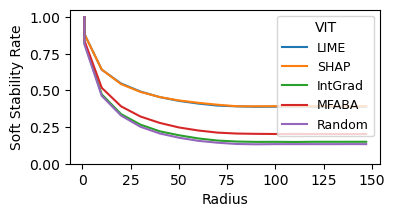

In [169]:
plt.clf()
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(4, 2))
plt.plot([1] + all_radius, torch.cat([torch.tensor([1]), lime_stability_rates.cpu().mean(dim=0)]).numpy(), label="LIME")
plt.plot([1] + all_radius, torch.cat([torch.tensor([1]), shap_stability_rates.cpu().mean(dim=0)]).numpy(), label="SHAP")
plt.plot([1] + all_radius, torch.cat([torch.tensor([1]), intgrad_stability_rates.cpu().mean(dim=0)]).numpy(), label="IntGrad")
plt.plot([1] + all_radius, torch.cat([torch.tensor([1]), mfaba_stability_rates.cpu().mean(dim=0)]).numpy(), label="MFABA")
plt.plot([1] + all_radius, torch.cat([torch.tensor([1]), random_stability_rates.cpu().mean(dim=0)]).numpy(), label="Random")
plt.ylim(0,1.05)

plt.xlabel('Radius')
plt.ylabel('Soft Stability Rate')
plt.legend(title="VIT", loc="upper right", prop={'size': 9})
# plt.title('Soft Stability')
plt.savefig('_dump/vit_imagenet_soft.pdf', bbox_inches="tight")
plt.show()


## As a comparison, here are the certified radii when old-MuS uses lambda=0.25

In [148]:
cert_mus_vit = CertifiedMuSImageClassifier(raw_vit, lambda_=0.25)

In [150]:
# cert_lime_stability_rates = torch.cat([
#     cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
#     for img, exp in tqdm(zip(images, lime_explanations), total=len(images))
# ], dim=0).cpu()

# cert_shap_stability_rates = torch.cat([
#     cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
#     for img, exp in tqdm(zip(images, shap_explanations), total=len(images))
# ], dim=0).cpu()

# cert_intgrad_stability_rates = torch.cat([
#     cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
#     for img, exp in tqdm(zip(images, intgrad_explanations), total=len(images))
# ], dim=0).cpu()

# cert_mfaba_stability_rates = torch.cat([
#     cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
#     for img, exp in tqdm(zip(images, mfaba_explanations), total=len(images))
# ], dim=0).cpu()
cert_random_stability_rates = torch.cat([
    cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
    for img, exp in tqdm(zip(images, random_explanations), total=len(images))
], dim=0).cpu()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [151]:
# torch.save(cert_lime_stability_rates, cache_dir / "vit_lime_cert_stability_rates.pt")
# torch.save(cert_shap_stability_rates, cache_dir / "vit_shap_cert_stability_rates.pt")
# torch.save(cert_intgrad_stability_rates, cache_dir / "vit_intgrad_cert_stability_rates.pt")
# torch.save(cert_mfaba_stability_rates, cache_dir / "vit_mfaba_cert_stability_rates.pt")
torch.save(cert_random_stability_rates, cache_dir / "vit_random_cert_stability_rates.pt")

In [152]:
cert_lime_stability_rates = torch.load(cache_dir / "vit_lime_cert_stability_rates.pt")
cert_shap_stability_rates = torch.load(cache_dir / "vit_shap_cert_stability_rates.pt")
cert_intgrad_stability_rates = torch.load(cache_dir / "vit_intgrad_cert_stability_rates.pt")
cert_mfaba_stability_rates = torch.load(cache_dir / "vit_mfaba_cert_stability_rates.pt")
cert_mfaba_stability_rates = torch.load(cache_dir / "vit_random_cert_stability_rates.pt")

<Figure size 640x480 with 0 Axes>

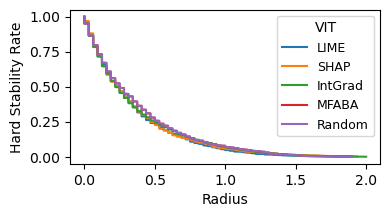

In [155]:
plt.clf()
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(4, 2))
plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="LIME")
plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="SHAP")
plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="IntGrad")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="MFABA")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="Random")

plt.xlabel('Radius')
plt.ylabel('Hard Stability Rate')
plt.legend(title="VIT", loc="upper right", prop={'size': 9})
# plt.title('Hard Stability')
plt.savefig('_dump/vit_imagenet_hard.pdf', bbox_inches="tight")
plt.show()


## Combine soft and hard stability in the same plot

In [ ]:
# plt.clf()
# plt.figure(figsize=(6, 4))
# plt.plot(all_radius, lime_stability_rates.cpu().mean(dim=0).numpy(), label="LIME Soft")
# plt.plot(all_radius, shap_stability_rates.cpu().mean(dim=0).numpy(), label="SHAP Soft")
# plt.plot(all_radius, intgrad_stability_rates.cpu().mean(dim=0).numpy(), label="IntGrad Soft")
# plt.plot(all_radius, mfaba_stability_rates.cpu().mean(dim=0).numpy(), label="MFABA Soft")

# plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="LIME Hard", color="#1f77b4")
# plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="SHAP Hard", color="#ff7f0e")
# plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="IntGrad Hard", color="#2ca02c")
# plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="MFABA Hard", color="#d62728")
# plt.xlabel('Radius')
# plt.ylabel('Stability Rate')
# plt.legend(title="ViT", loc="upper right", prop={'size': 7})
# plt.title('Soft vs. Hard Stability')
# plt.savefig('_dump/vit_imagenet_softvhard_1k', bbox_inches="tight")
